# Deep InteractionNetwork for Jet tagging using jet constituents from HLS data using CONV1D layers for multiplications
Author: Andre Sznajder

Inspired on J.Duarte, M.Pierini & all PYTORCH implementation of JEDI Network:
https://github.com/jmduarte/JEDInet-code/blob/master/jupyter/IN_correlations.ipynb

And Thong Q. Nguyen TENSORFLOW implementation
https://github.com/thongonary/HbbIN/blob/master/interaction.py

Original Interaction Natworks paper:
https://arxiv.org/pdf/1612.00222.pdf

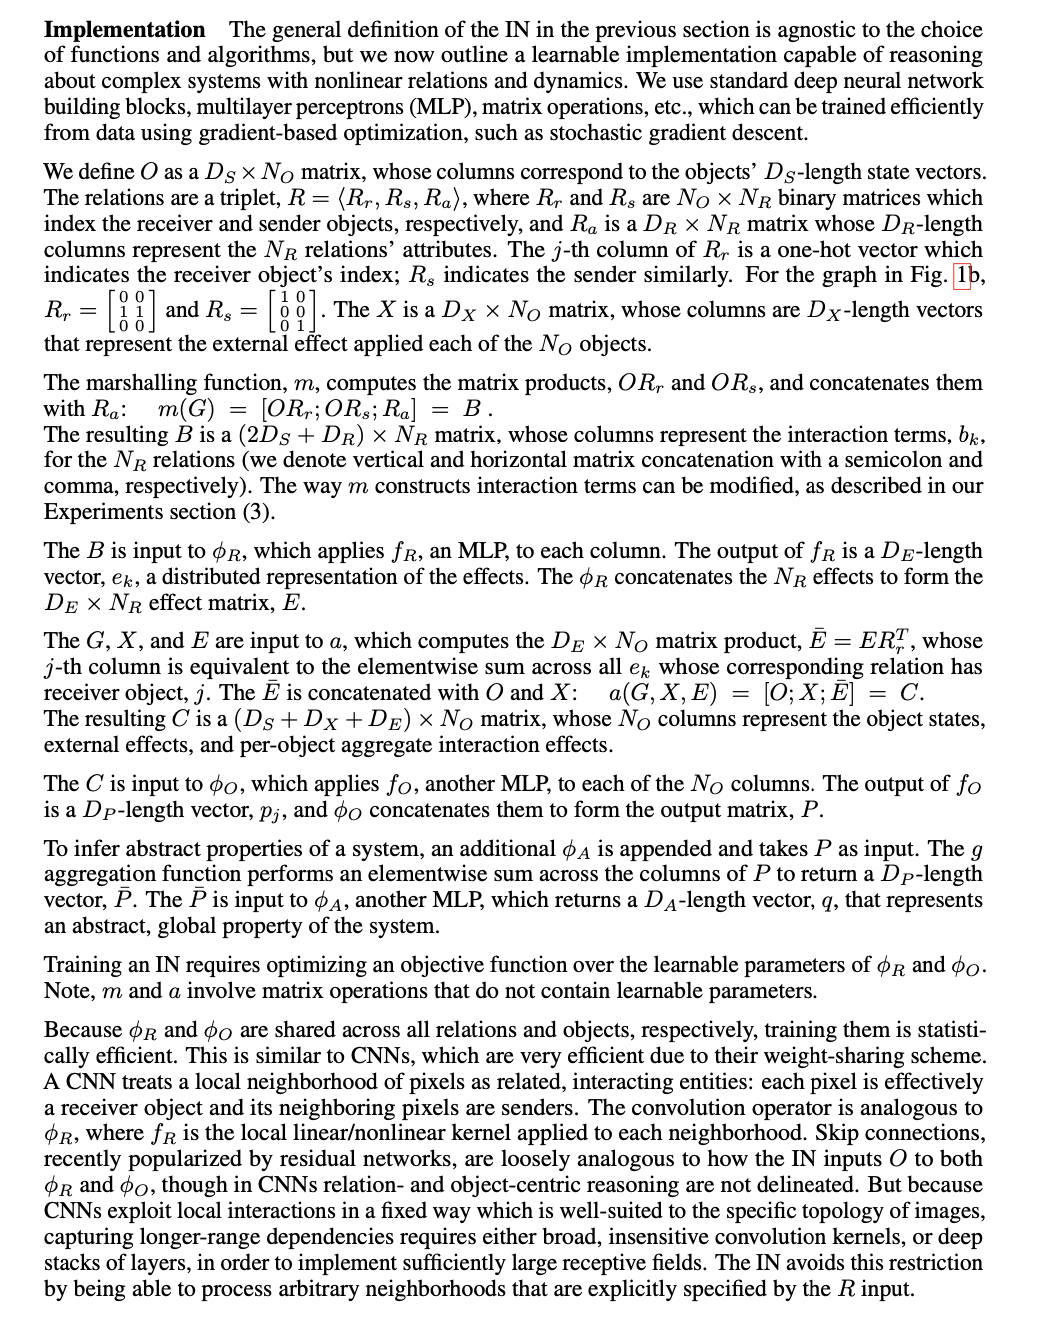

# Load HLS4ML dataset 

Here, we load the numpy arrays containing the 4D tensors of "jet-images" (see https://arxiv.org/pdf/1511.05190.pdf)

https://github.com/pierinim/tutorials/blob/master/GGI_Jan2021/Lecture1/Notebook1_ExploreDataset.ipynb

 * `jetImage` contains the image representation of the jets (more later)
 * `jetImageECAL` and `jetImageHCAL` are the ECAL- and HCAL-only equivalent images. We will not use them (but you are more than welcome to play with it)
 * `jetConstituentList` is the list of particles cointained in the jet. For each particle, a list of relevant quantities is stored
 * `particleFeatureNames` is the list of the names corresponding to the quantities contained in `jetConstituentList`; `jets` is the dataset we consider for the moment
 * `jetFeatureNames` is the list of the names corresponding to the quantities contained in `jets`

In [1]:
import numpy as np
import h5py
import os

# for pT, eta_rel, phi_rel
#   myJetConstituentList = np.array(f.get("jetConstituentList")[:,:,[5,8,11]])
# for px, py, pz
#   myJetConstituentList = np.array(f.get("jetConstituentList")[:,:,[0,1,2]])
#   myJetConstituentList = np.array(f.get("jetConstituentList"))
#
# Jet Constituents Features =  [0='j1_px', 1='j1_py', 2='j1_pz', 3='j1_e', 4='j1_erel', 5='j1_pt', 6='j1_ptrel',
#                         7='j1_eta', 8='j1_etarel', 9='j1_etarot', 10='j1_phi', 11='j1_phirel', 12='j1_phirot',
#                         13='j1_deltaR', 14='j1_costheta', 15='j1_costhetarel', 16='j1_pdgid']

#Data PATH
TRAIN_PATH = '/Users/sznajder/WorkM1/workdir/data/hls4ml_LHCjet_150p/'



first=True
for file in os.listdir(TRAIN_PATH):
  print("Appending %s" %file)

  with h5py.File(TRAIN_PATH+file, 'r') as data:
    if first : 
        first=False
        jetConstituent = data['jetConstituentList'][:,:,[5,8,11]]
        target = data['jets'][:,-6:-1]
        print("Keys in H5PY files = ",list( data.keys() ))
        print(" ")
        featurenames = data.get('jetFeatureNames')
        print("Jets Features = ",featurenames[:])
        print(" ")
        featurenames = data.get('particleFeatureNames')
        print("Jet Constituents Features = ",featurenames[:])
        print(" ")
        images = data.get('jetImage')
        print("Jet Images = ",images[:])        
        print("Jet Image Shape = ",images.shape)   
        print(" ")
    else:
         # Read (Pt,Etarel,Phirel)
        jetConstituent = np.concatenate( [ jetConstituent, data['jetConstituentList'][:,:,[5,8,11]] ] , axis=0 )
        target   = np.concatenate( [ target, data['jets'][:,-6:-1] ] , axis=0 )

print("Target shape =", target.shape)
print("Jet Constituents shape =", jetConstituent.shape)

Appending jetImage_6_150p_40000_50000.h5
Keys in H5PY files =  ['jetConstituentList', 'jetFeatureNames', 'jetImage', 'jetImageECAL', 'jetImageHCAL', 'jets', 'particleFeatureNames']
 
Jets Features =  [b'j_ptfrac' b'j_pt' b'j_eta' b'j_mass' b'j_tau1_b1' b'j_tau2_b1'
 b'j_tau3_b1' b'j_tau1_b2' b'j_tau2_b2' b'j_tau3_b2' b'j_tau32_b1'
 b'j_tau32_b2' b'j_zlogz' b'j_c1_b0' b'j_c1_b1' b'j_c1_b2' b'j_c2_b1'
 b'j_c2_b2' b'j_d2_b1' b'j_d2_b2' b'j_d2_a1_b1' b'j_d2_a1_b2' b'j_m2_b1'
 b'j_m2_b2' b'j_n2_b1' b'j_n2_b2' b'j_tau1_b1_mmdt' b'j_tau2_b1_mmdt'
 b'j_tau3_b1_mmdt' b'j_tau1_b2_mmdt' b'j_tau2_b2_mmdt' b'j_tau3_b2_mmdt'
 b'j_tau32_b1_mmdt' b'j_tau32_b2_mmdt' b'j_c1_b0_mmdt' b'j_c1_b1_mmdt'
 b'j_c1_b2_mmdt' b'j_c2_b1_mmdt' b'j_c2_b2_mmdt' b'j_d2_b1_mmdt'
 b'j_d2_b2_mmdt' b'j_d2_a1_b1_mmdt' b'j_d2_a1_b2_mmdt' b'j_m2_b1_mmdt'
 b'j_m2_b2_mmdt' b'j_n2_b1_mmdt' b'j_n2_b2_mmdt' b'j_mass_trim'
 b'j_mass_mmdt' b'j_mass_prun' b'j_mass_sdb2' b'j_mass_sdm1'
 b'j_multiplicity' b'j_g' b'j_q' b'j_w' b'j_z' b'

KeyboardInterrupt: 

# The image dataset

Jets can be converted to images considering the (&eta;, &phi;) plane, centered along the axis direction and binned.
In our case, we consider a square of 1.6x1.6 in size (because the jet size is R=0.8) binned in 100x100 equal-size 'cells'


The ground truth is incorporated in the `['g', 'q', 'w', 'z', 't']` vector of boolean, taking the form
- `[1, 0, 0, 0, 0]` for gluons
- `[0, 1, 0, 0, 0]` for quarks
- `[0, 0, 1, 0, 0]` for Ws
- `[0, 0, 0, 1, 0]` for Zs
- `[0, 0, 0, 0, 1]` for tops

This is what is called 'one-hot' encoding of a descrete label (typical of ground truth for classification problems)

In [ ]:
from einops import rearrange, reduce, repeat

# Convert target format from one-hot encoding to single neuron
#target = np.argmax(target, axis=1)

# The dataset is N_jets x N_constituents x N_features
njet     = jetConstituent.shape[0]
nconstit = jetConstituent.shape[1]
nfeat    = jetConstituent.shape[2]


# Filter out constituents with Pt<2GeV
Ptmin =2. 
constituents = np.zeros((njet, nconstit, nfeat) , dtype=np.float32) 
ij=0
max_constit=0
for j in range(njet):
    ic=0
    for c in range(nconstit):
        if ( jetConstituent[j,c,0] < Ptmin ):
            continue
        constituents[ij,ic,:] = jetConstituent[j,c,:] 
        ic+=1
    if (ic > 0):
        if ic > max_constit: max_constit=ic
        target[ij,:]=target[j,:] # assosicate the correct target a given graph 
        ij+=1


# Resizes the jets constituents and target arrays        
jetConstituent = constituents[0:ij,0:max_constit,:]
target = target[0:ij,:]


# Restric the number of constituents to a maximum of NMAX
nmax = 8
jetConstituent = jetConstituent[:,0:nmax,:]

# The dataset is N_jets x N_constituents x N_features
njet     = jetConstituent.shape[0]
nconstit = jetConstituent.shape[1]
nfeat    = jetConstituent.shape[2]


print('Number of jets =',njet)
print('Number of constituents =',nconstit)
print('Number of features =',nfeat)


# Shuffles jet constituents
print("Before --->> jetConstituent[0,0:4,0] = ",jetConstituent[0,0:4,0])
for i in range(jetConstituent.shape[0]):
  jetConstituent[i] = jetConstituent[i, np.random.permutation(nconstit), :]
print("After --->> jetConstituent[0,0:4,0] = ",jetConstituent[0,0:4,0])


## Dividing the data into testing and training dataset

We will split the data into two parts (one for training+validation and one for testing) 

In [ ]:
from sklearn.model_selection import train_test_split

X = jetConstituent
Y = target
del jetConstituent , target

X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

print(X_train_val.shape, X_test.shape, Y_train_val.shape, Y_test.shape)

print('number of G jets for training/validation: %i'%np.sum( np.argmax(Y_train_val, axis=1)==0 ))
print('number of Q jets for training/validation: %i'%np.sum( np.argmax(Y_train_val, axis=1)==1 ))
print('number of W jets for training/validation: %i'%np.sum( np.argmax(Y_train_val, axis=1)==2 ))
print('number of Z jets for training/validation: %i'%np.sum( np.argmax(Y_train_val, axis=1)==3 ))
print('number of T jets for training/validation: %i'%np.sum( np.argmax(Y_train_val, axis=1)==4 ))


print('number of G jets for testing: %i'%np.sum( np.argmax(Y_test, axis=1)==0 ))
print('number of Q jets for testing: %i'%np.sum( np.argmax(Y_test, axis=1)==1 ))
print('number of W jets for testing: %i'%np.sum( np.argmax(Y_test, axis=1)==2 ))
print('number of Z jets for testing: %i'%np.sum( np.argmax(Y_test, axis=1)==3 ))
print('number of T jets for testing: %i'%np.sum( np.argmax(Y_test, axis=1)==4 ))

## Interaction Network Model from JEDI ( Jet ID ) paper:
https://arxiv.org/pdf/1908.05318.pdf


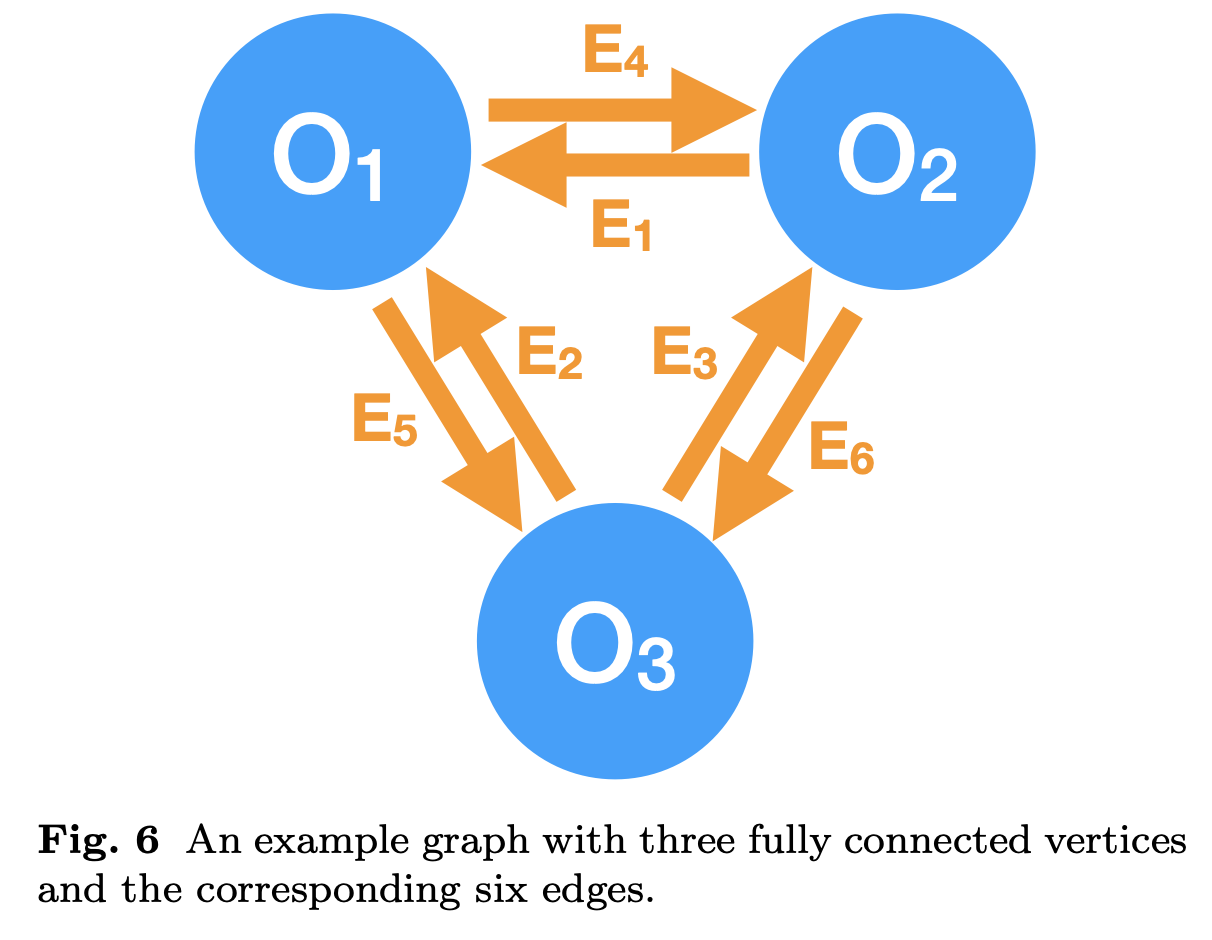

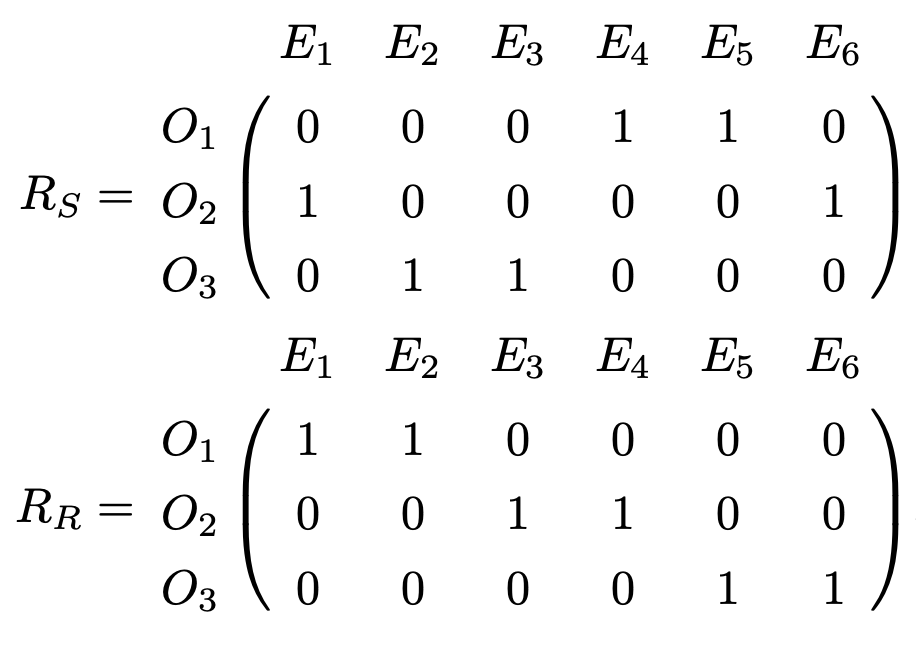

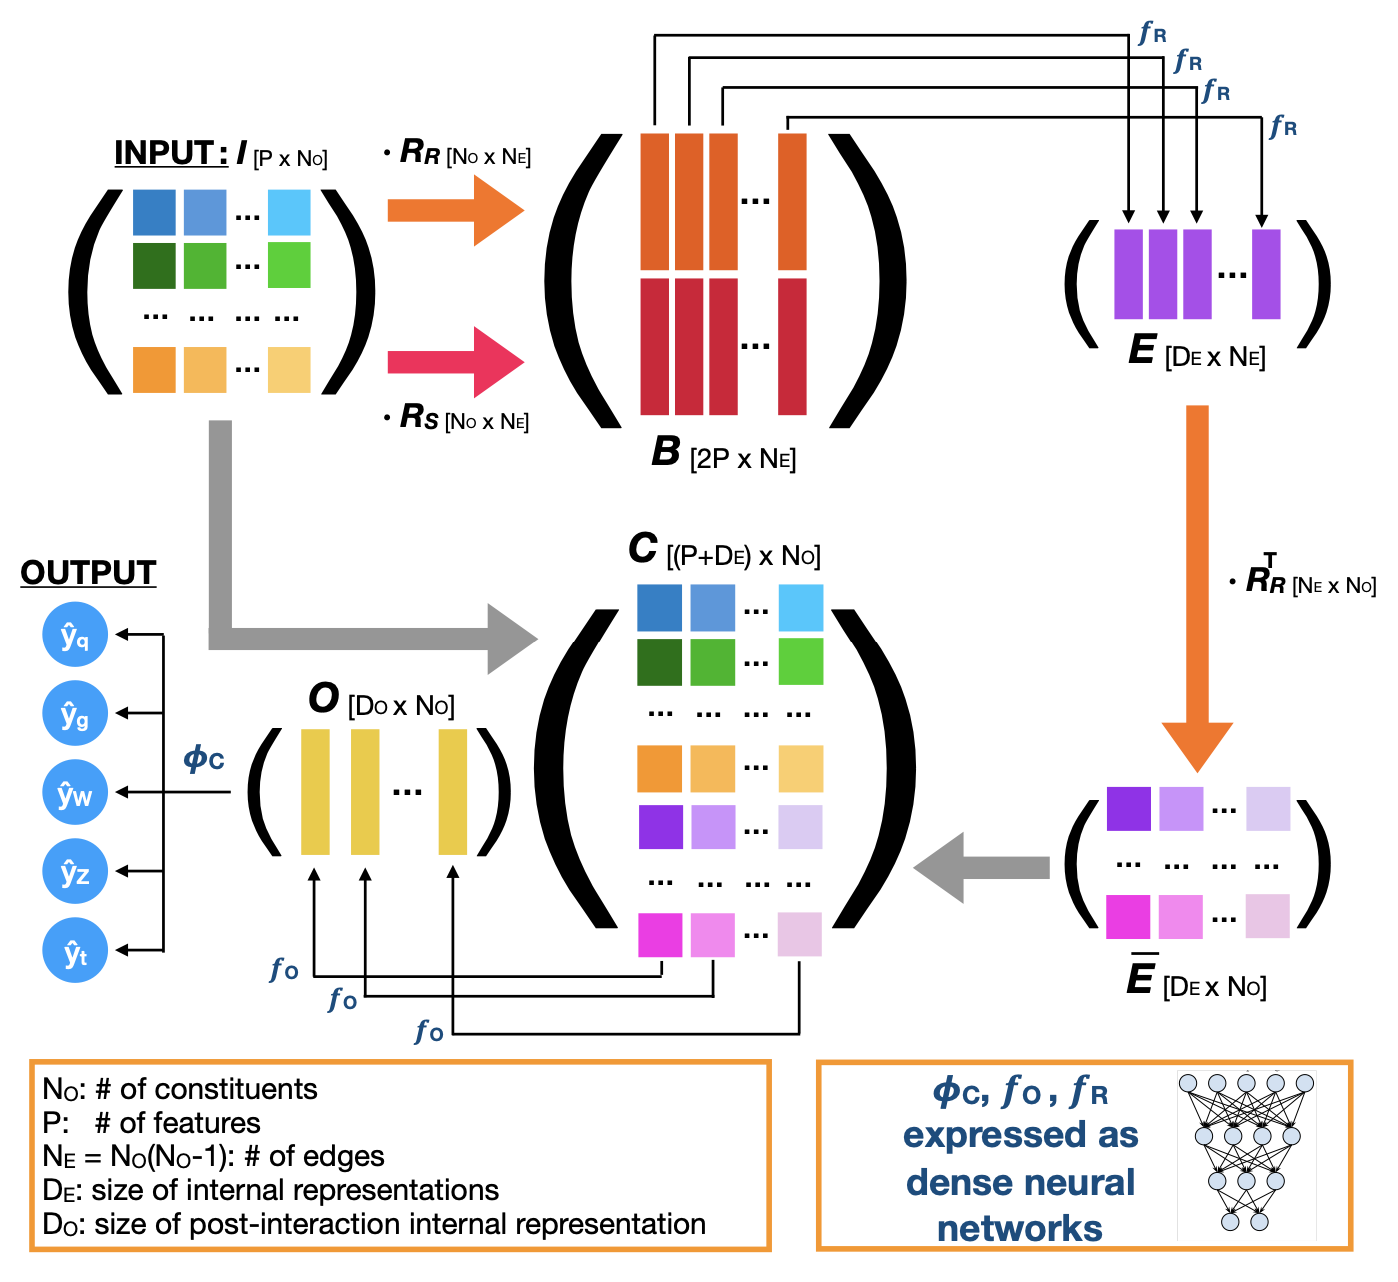



In [ ]:
"""
Tensorflow implementation of the Interaction networks auxiliar functions

"""

import tensorflow as tf
import numpy as np
        
# Create the sender and receiver relations matrices ( incidence matrices ) as a fully conected graph
def assign_matrices(N,Nr):
    Rr = np.zeros([N, Nr], dtype=np.float32)
    Rs = np.zeros([N, Nr], dtype=np.float32)
    receiver_sender_list = [i for i in itertools.product(range(N), range(N)) if i[0]!=i[1]]
    for i, (r, s) in enumerate(receiver_sender_list):
        Rr[r, i]  = 1
        Rs[s, i] = 1
    return Rs, Rr

## Interaction Network Model

In [ ]:
# baseline keras model
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Permute, Concatenate, Flatten, Reshape, BatchNormalization, Activation, Dense
from tensorflow.keras.optimizers import SGD, Adam, Nadam
from tensorflow.keras import utils
from qkeras import QDense, QActivation, quantized_bits
import itertools

njet     = X_train_val.shape[0]
nconstit = X_train_val.shape[1]
ntargets =  Y_train_val.shape[1]
nfeat =  X_train_val.shape[2]


print("#jets = ",njet)
print("#constituents = ",nconstit)
print("#targets = ",ntargets)
print("#features = ",nfeat)

###############################################################
'''
# Params for 32 constituents
De=6                  # size of latent edges features representations
Do=6                  # size of latent nodes features representations
scale_e = 5           # multiplicative factor for # hidden neurons in Edges MLP 
scale_n = 5           # multiplicative factor for # hidden neurons in Nodes MLP 
scale_g = 0.1           # multiplicative factor for # hidden neurons in Graph MLP 
'''

'''
# Params for 16 constituents
De=6                  # size of latent edges features representations
Do=6                  # size of latent nodes features representations
scale_e = 7           # multiplicative factor for # hidden neurons in Edges MLP 
scale_n = 7           # multiplicative factor for # hidden neurons in Nodes MLP 
scale_g = 0.35           # multiplicative factor for # hidden neurons in Graph MLP 
'''

#'''
 Params for 8 constituents
De=6                  # size of latent edges features representations
Do=6                  # size of latent nodes features representations
scale_e = 2           # multiplicative factor for # hidden neurons in Edges MLP 
scale_n = 2           # multiplicative factor for # hidden neurons in Nodes MLP 
scale_g = 1.5           # multiplicative factor for # hidden neurons in Graph MLP 
#'''



# Interaction Network model parameters
N = nconstit
P = nfeat
Nr = N*(N-1) # number of relations ( edges )
Dr = 0                     
Dx = 0


# Print
print("Trainign with max # of contituents = ", nconstit)
print("Number of node features = ", nfeat)

##########################################################################    

## Define the Interaction Network model ##    

###############################################################


# Matrix of relations features (Dr X Nr) initializes as ones        
#Ra = tf.ones([Dr, Nr])  

### Format input into fully contected graph  ###

###################################################################################
        
# Matrix of relations features (Dr X Nr) initializes as ones        
#Ra = tf.ones([Dr, Nr])  

# Input shape
inp = Input(shape=(nconstit, nfeat), name="in_layer")
       
# Batch normalize the inputs
x = BatchNormalization(name='batchnorm')(inp)

# Swap axes of input data (batch,nodes,features)->(batch,features,nodes)
#x = tf.transpose(x, perm=[0, 2, 1])  
x = Permute((2, 1), input_shape=x.shape[1:])(x)

# Create a fully conected adjacency matrix ( sender and receiver incidence matrices format )
Rs, Rr = assign_matrices(N,Nr)

# Marshaling function ( use Conv1D to multiply matrices )
ORr = Conv1D(Rr.shape[1], kernel_size=1, use_bias=False, trainable=False, name='tmul_1')(x)
ORs = Conv1D(Rs.shape[1], kernel_size=1, use_bias=False, trainable=False, name='tmul_2')(x)
B = Concatenate(axis=1)([ORr, ORs])  # Concatenates Or and Os  ( no relations features Ra matrix )

###################################################################################
### Edges MLP ( takes as inputs nodes features and fully conected graph edges ) ###

# Transpose input matrix permutating columns 1&2
inp_e = Permute((2, 1), input_shape=B.shape[1:])(B)

# Define the Edges MLP layers
nhidden_e = int( (2 * P + Dr)*scale_e )
h = Conv1D(nhidden_e, kernel_size=1, name='conv1D_e1')(inp_e)
h = Activation('relu', name='relu_e1')(h)
h = Conv1D(int(nhidden_e/2), kernel_size=1, name='conv1D_e2')(h)
h = Activation('relu', name='relu_e2')(h)
h = Conv1D(De, kernel_size=1, name='conv1D_e3')(h)
out_e = Activation('relu', name='relu_e3')(h)

# Transpose output and permutes columns 1&2  
out_e = Permute((2, 1))(out_e)

# Multiply edges MLP output by receiver nodes matrix Rr ( use Conv1D to multiply matrices )
out_e = Conv1D(np.transpose(Rr).shape[1], kernel_size=1, use_bias=False, trainable=False, name='tmul_3')(out_e)

##############################################################################
### Nodes MLP ( takes as inputs node features and embeding from edges MLP )###

# Concatenate input Node features and Edges MLP output for the Nodes MLP input
inp_n = Concatenate(axis=1)([x, out_e])   #  Original IN was C = tf.concat([N,x,E], axis=1) 

# Transpose input and permutes columns 1&2
inp_n = Permute((2, 1), input_shape=inp_n.shape[1:])(inp_n)

# Define the Nodes MLP layers
nhidden_n = int( (P + Dx + De)*scale_n ) # number of neurons in Nodes MLP hidden layer 
h = Conv1D(nhidden_n, kernel_size=1, name='conv1D_n1')(inp_n)
h = Activation('relu', name='relu_n1')(h)
h = Conv1D(int(nhidden_n/2), kernel_size=1, name='conv1D_n2')(h)
h = Activation('relu', name='relu_n2')(h)
h = Conv1D(Do, kernel_size=1, name='conv1D_n3' )(h)
out_n = Activation('relu', name='relu_n3')(h)

#################################
###  Graph classification MLP ###

# Flatten input for the Graph classifier MLP
inp_g = Flatten()(out_n)

# Define Graph classifier MLP  layers
nhidden_g = int( (Do * N)*scale_g )  # Number of nodes in graph MLP hidden layer
h = Dense(nhidden_g, name='dense_g1' )(inp_g)
h = Activation('relu', name='relu_g1')(h)
h = Dense(ntargets, name='dense_g2')(h)
out = Activation('softmax',name='softmax_g2')(h)

  
######################################################################################


# create the model
model = Model(inputs=inp, outputs=out)


# Define the optimizer ( minimization algorithm )
#optim = SGD(learning_rate=0.0001,decay=1e-6)
#optim = Nadam(learning_rate=0.0005)
optim = Adam(learning_rate=0.0002)
#optim = Adam()


# Compile the Model
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['categorical_accuracy'])


# Model Summary
model.summary()


# Set non-treinable weights for multiplications in HLS4ML friendly way ( J.Duarte MODS )
model.get_layer('tmul_1').set_weights([Rr])
model.get_layer('tmul_2').set_weights([Rs])
model.get_layer('tmul_3').set_weights([np.transpose(Rr)])
print(model.get_layer('tmul_3').get_weights())


## Run training
Here, we run the training.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

# early stopping callback
es = EarlyStopping(monitor='val_categorical_accuracy', patience=10)

# Learning rate scheduler 
ls = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=10)

# model checkpoint callback
# this saves our model architecture + parameters into mlp_model.h5
chk = ModelCheckpoint('InteractionNetworkConv1D_chkp.h5', monitor='val_loss', 
                                   verbose=1, save_best_only=True, 
                                   save_weights_only=False, mode='auto', 
                                   save_freq='epoch')


# Train classifier
history = model.fit( X_train_val , Y_train_val, 
                    epochs=200, 
                    batch_size=512, 
                    verbose=1,
                    callbacks=[es,ls,chk], 
                    validation_split=0.3 )   


# Set model and output name
arch = 'InteractionNetwork_CONV1D'
fname = arch+'_nconst_'+str(nmax)
print('Saving Model : ',fname)


## Save the model+ weights
model.save('model_'+fname+'.h5')

## Save the model weights in a separate file
model.save_weights('weights_'+fname+'.h5')

## Plot performance
Here, we plot the history of the training and the performance in a ROC curve

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

#plt.rcParams['axes.unicode_minus'] = False

# Plot loss vs epoch
plt.figure(figsize=(15,10))
ax = plt.subplot(2, 2, 1)
ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val loss')
ax.legend(loc="upper right")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

# Plot accuracy vs epoch
ax = plt.subplot(2, 2, 2)
ax.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
ax.plot(history.history['val_categorical_accuracy'], label='val categorical accuracy')
ax.legend(loc="upper left")
ax.set_xlabel('epoch')
ax.set_ylabel('acc')

# Plot the ROC curves
labels = ['gluon', 'quark', 'W', 'Z', 'top']
fpr = {}
tpr = {}
auc1 = {}
precision = {}
recall = {}
NN = {}
NP = {}
TP = {}
FP = {}
TN = {}
FN = {}
tresholds = {}

# Get model predictions
Y_predict = model.predict(X_test)

# Loop over classes(labels) to get metrics per class
ax = plt.subplot(2, 2, 3)
for i, label in enumerate(labels):
    fpr[label], tpr[label], tresholds[label] = roc_curve(Y_test[:,i], Y_predict[:,i])
#    precision[label], recall[label], tresholds = precision_recall_curve(Y_test[:,i], Y_predict[:,i]) 
    print( np.unique(Y_test[:,i], return_counts=True) )
    _ , N = np.unique(Y_test[:,i], return_counts=True) # count the NEGATIVES and POSITIVES samples in your test set
    NN[label] = N[0]                   # number of NEGATIVES 
    NP[label] = N[1]                   # number of POSITIVES
    TP[label] = tpr[label]*NP[label]
    FP[label] = fpr[label]*NN[label] 
    TN[label] = NN[label] - FP[label]
    FN[label] = NP[label] - TP[label]

    auc1[label] = auc(fpr[label], tpr[label])
    ax.plot(tpr[label],fpr[label],label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.))
    
ax.semilogy()
ax.set_xlabel("sig. efficiency")
ax.set_ylabel("bkg. mistag rate")
ax.set_ylim(0.001,1)
#ax.set_grid(True)
ax.legend(loc='lower right')
#plt.savefig('%s/ROC.pdf'%(options.outputDir))

print('Tresholds=',tresholds)

# Plot DNN output 
ax = plt.subplot(2, 2, 4)
X = np.linspace(0.0, 1.0, 20)
hist={}
for i, name in enumerate(labels):
    hist[name] = ax.hist(Y_predict, bins=X, label=name ,histtype='step')

ax.semilogy()
ax.set_xlabel('DNN Output')
ax.legend(loc='lower left')
ax.legend(prop={'size': 10})

# Display plots
fig = plt.gcf()
plt.show()    

In [ ]:
from sklearn.metrics import accuracy_score

# Save plots
fig.savefig(fname+'.pdf')


# Save FPR for a given TPR value ( 30% , 50% & 80%)
with open('FPR@TPR_'+fname+'.csv', 'w') as file:
  file.write("model,label,treshold,tpr,fpr\n")
  for label in labels:
    for t in [0.3, 0.5, 0.8]:
      idx = np.argmax(tpr[label]>t)
      file.write( arch+','+label+','+str(t)+','+str(tpr[label][idx])+','+str(fpr[label][idx])+'\n' )
               
               
# Save ROC AUC for each label
with open('ROCAUC_'+fname+'.csv', 'w') as file:
  header = labels[0]+', '+labels[1]+', '+labels[2]+', '+labels[3]+', '+labels[4]+'\n'
  file.write(header)
  rocauc = str(auc1[labels[0]])+', '+str(auc1[labels[1]])+', '+str(auc1[labels[2]])+', '+str(auc1[labels[3]])+', '+str(auc1[labels[4]])
  file.write(rocauc)



# Save NN Accuracy for treshold of 0.5 for each label and the average over all classes
acc_avg = float(accuracy_score (np.argmax(Y_test,axis=1), np.argmax(Y_predict,axis=1)))
with open('ACCURACY_'+fname+'.csv', 'w') as file:
  header = labels[0]+', '+labels[1]+', '+labels[2]+', '+labels[3]+', '+labels[4]+', '+'acc_avg'+'\n'
  file.write(header)
  accuracy = ''
  for label in labels:  
    idx = np.argmax( tresholds[label] <= 0.5 )
    accuracy += str( (TP[label][idx]+TN[label][idx])/(NP[label]+NN[label]) )+', '
  accuracy += str(acc_avg) 
  file.write(accuracy)


'''
# Save confusion matrix ndarrays to .npz file
with open('CONF_MATRIX_'+fname+'.npz', 'wb') as file:
    vars = {}
    vars[arch]=np.array(1) # save model name
    for label in labels:
        vars['tresholds_'+label+'_'+arch] = tresholds[label]
        vars['TP_'+label+'_'+arch] = TP[label]
        vars['FP_'+label+'_'+arch] = FP[label]
        vars['TN_'+label+'_'+arch] = TN[label]
        vars['FN_'+label+'_'+arch] = FN[label]
        vars['TPR_'+arch] = tpr[label]
        vars['FPR_'+arch] = fpr[label]
        vars['NP_'+arch]= NP[label]
        vars['NN_'+arch]= NN[label]
        vars['auc_'+arch] = auc1[label] 
#        print(vars)
    np.savez(file, **vars)
'''


# Save a sample of events for HLS
njets=3000
print(X_test.shape)
np.save('x_test_8const.npy', X_test[0:njets,:])
np.save('y_test_8const.npy', Y_test[0:njets,:])

